In [1]:
import yaml
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from types import SimpleNamespace
import numpy as np
import os
import pandas as pd
import json
import scipy
import rasterio
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from matplotlib.colors import ListedColormap
from adjustText import adjust_text
from sklearn.covariance import EllipticEnvelope
from matplotlib.patches import Ellipse
from scipy.spatial import distance
from matplotlib.ticker import ScalarFormatter
import math
from scipy.optimize import curve_fit
import cv2
from sklearn.metrics import pairwise_distances
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import euclidean_distances
from scipy.stats import ttest_rel
from rasterio.transform import xy
from math import radians, cos, sin, sqrt, atan2
from rasterio.transform import Affine
import matplotlib as mpl
from matplotlib.ticker import MaxNLocator
import matplotlib.ticker as mticker
import pickle
import h5py
from matplotlib import font_manager as fm
import feather
from scipy.ndimage import binary_erosion

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['font.size'] = 5         # 全域預設的文字大小
mpl.rcParams['axes.labelsize'] = 7    # x, y 軸標籤 (label) 的文字大小
mpl.rcParams['xtick.labelsize'] = 5    # x 軸刻度 (tick) 的文字大小
mpl.rcParams['ytick.labelsize'] = 5   # y 軸刻度 (tick) 的文字大小
mpl.rcParams['legend.fontsize'] = 5
mpl.rcParams['axes.linewidth'] = 0.5
mpl.rcParams['ytick.major.width'] = 0.5
mpl.rcParams['xtick.major.width'] = 0.5
mpl.rcParams['xtick.major.size'] = 2.5
mpl.rcParams['ytick.major.size'] = 2.5
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['Arial']
mpl.rcParams['boxplot.boxprops.linewidth'] = 0.5
mpl.rcParams['boxplot.medianprops.linewidth'] = 0.5
mpl.rcParams['boxplot.whiskerprops.linewidth'] = 0.5
mpl.rcParams['boxplot.capprops.linewidth'] = 0.5
mpl.rcParams['boxplot.flierprops.markersize'] = 0.5
mpl.rcParams['legend.frameon'] = False

In [2]:
run_id = 'e52c8ac9a3e24c75ac871f63bbdea060'
exp_id = '115656750127464383'

## 會用到的函數

In [3]:
def create_folder(file_path):
    if not os.path.exists(file_path):
        os.makedirs(file_path)
        
def cov_center(data, level=0.95):
    env = EllipticEnvelope(support_fraction=level).fit(data)
    center = env.location_
    covariance = env.covariance_
    return center, covariance

def plot_ellipse(center, covariance, ax, n_std=2.0, facecolor='none', **kwargs):
    """
    在给定的轴上绘制一个椭圆。

    :param center: 椭圆的中心点。
    :param covariance: 椭圆的协方差矩阵。
    :param ax: matplotlib 轴对象。
    :param n_std: 确定椭圆大小的标准差倍数。
    :param facecolor: 椭圆的填充颜色。
    :param kwargs: 传递给 Ellipse 对象的其他参数。
    """
    # 计算协方差矩阵的特征值和特征向量
    eigenvals, eigenvecs = np.linalg.eigh(covariance)
    order = eigenvals.argsort()[::-1]
    eigenvals, eigenvecs = eigenvals[order], eigenvecs[:, order]

    # 计算椭圆的宽度和高度
    width, height = 2 * n_std * np.sqrt(eigenvals)
    angle = np.degrees(np.arctan2(*eigenvecs[:,0][::-1]))

    # 创建并添加椭圆形状
    ellipse = Ellipse(xy=center, width=width, height=height, angle=angle, facecolor=facecolor, **kwargs)
    ax.add_patch(ellipse)
    
def png_operation(rst):
    grid_normalized = cv2.normalize(rst, None, 0, 255, cv2.NORM_MINMAX)
    grid_uint8 = grid_normalized.astype(np.uint8)
    colored_image = cv2.applyColorMap(grid_uint8, cv2.COLORMAP_JET)
    # 設定要調整的尺寸，例如 300x300
    new_size = (300, 300)
    # 調整 PNG 的大小
    resized_png = cv2.resize(colored_image, new_size, interpolation=cv2.INTER_CUBIC)
    return resized_png

# 計算兩個經緯度點之間的距離，支持向量化操作
def haversine(lat1, lon1, lat2, lon2):
    R = 6371.0  # 地球半徑，單位：公里
    lat1, lon1 = np.radians(lat1), np.radians(lon1)
    lat2, lon2 = np.radians(lat2), np.radians(lon2)
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return R * c
def create_figure_mm(width_mm, height_mm, dpi=100):
    """
    根據毫米為單位的寬度和高度創建圖形
    :param width_mm: 寬度（以毫米為單位）
    :param height_mm: 高度（以毫米為單位）
    :param dpi: 圖形的分辨率（每英寸的點數）
    :return: fig, ax 圖形和軸對象
    """
    width_inch = width_mm / 25.4  # 將寬度從毫米轉換為英寸
    height_inch = height_mm / 25.4  # 將高度從毫米轉換為英寸
    fig, ax = plt.subplots(figsize=(width_inch, height_inch), dpi=dpi)
    return fig, ax
def get_significance_stars(p_value):
    if p_value <= 0.001:
        return '***'
    elif p_value <= 0.01:
        return '**'
    elif p_value <= 0.05:
        return '*'
    else:
        return ''
def get_chinese_sciname(target_name):
    change_names = {
    'Anas_zonorhyncha': 'Anas_poecilorhyncha', 
    'Cyanoderma_ruficeps': 'Stachyridopsis_ruficeps', 
    'Erythrogenys_erythrocnemis': 'Pomatorhinus_erythrocnemis', 
    'Ictinaetus_malaiensis': 'Ictinaetus_malayensis', 
    'Lewinia_striata': 'Gallirallus_striatus', 
    'Machlolophus_holsti': 'Parus_holsti', 
    'Pterorhinus_poecilorhynchus': 'Garrulax_poecilorhynchus', 
    'Pterorhinus_ruficeps': 'Garrulax_ruficeps', 
    'Schoeniparus_brunneus': 'Alcippe_brunnea', 
    'Sittiparus_castaneoventris': 'Poecile_varius', 
    'Synoicus_chinensis': 'Coturnix_chinensis', 
    'Taenioptynx_brodiei': 'Glaucidium_brodiei', 
    'Tarsiger_formosanus': 'Tarsiger_indicus', 
    'Turdus_niveiceps': 'Turdus_poliocephalus', 
    'Zapornia_fusca': 'Porzana_fusca'
    }
    df_name = pd.read_csv('../2023臺灣鳥類名錄-20230419.csv')
    for (new_name, orig_name) in change_names.items():
        if target_name == orig_name:
            target_name = new_name
            
    df_target = df_name[df_name['學名'] == target_name.replace('_', ' ')]
    return df_target['中文名'].values[0]
    
def mm2inch(*values):
    return [v / 25.4 for v in values]

In [4]:
# create a plot folder of the specific exp_id
plot_path = os.path.join('plots', run_id)
plot_path_df = os.path.join(plot_path, 'Fig4_dataframe')
plot_path_nichespace = os.path.join(plot_path, 'Fig4_niche_space')
plot_path_ecogeo_basedonDeepSDMpred = os.path.join(plot_path, 'Fig6_EcoGeo_comparison_basedonDeepSDMpred')
plot_path_biotop = os.path.join(plot_path, 'Fig6_biotop')
plot_path_subplots = os.path.join(plot_path, 'Fig6_subplots')
plot_path_nichespace_h5 = os.path.join(plot_path_nichespace, 'h5')
plot_path_flowchart = os.path.join(plot_path, 'Fig1_flowchart')
create_folder(plot_path_flowchart)

In [5]:
conf_path = os.path.join('mlruns', exp_id, run_id, 'artifacts', 'conf')
predicts_path = os.path.join('predicts', run_id)
with open(os.path.join(predicts_path, 'DeepSDM_conf.yaml'), 'r') as f:
    DeepSDM_conf = SimpleNamespace(**yaml.load(f, Loader = yaml.FullLoader))

with open(os.path.join(predicts_path, 'sp_inf.json'), 'r') as f:
    sp_inf = json.load(f)

with open(os.path.join(predicts_path, 'env_inf.json'), 'r') as f:
    env_inf = json.load(f)
    
with rasterio.open(os.path.join(conf_path, 'extent_binary.tif'), 'r') as f:
    extent_binary = f.read(1)
# load extent binary map
with rasterio.open(os.path.join(conf_path, 'extent_binary.tif'), 'r') as f:
    crs = f.crs
    transform = f.transform
    height, width = f.shape
    lon_min, lat_max = rasterio.transform.xy(transform, 0, 0)  # 左上角
    lon_max, lat_min = rasterio.transform.xy(transform, height - 1, width - 1)  # 右下角
    extent_binary = f.read(1)
    meta = f.meta.copy()
extent_binary_extent = [lon_min, lon_max, lat_min, lat_max]

In [6]:
deepsdm_h5_path = os.path.join('predicts', run_id, 'h5', '[SPECIES]', '[SPECIES].h5')
maxent_h5_path = os.path.join('predict_maxent', run_id, 'h5', 'all', '[SPECIES]', '[SPECIES].h5')

In [7]:
species_list_predict = sorted(DeepSDM_conf.training_conf['species_list_predict'])
date_list_train = DeepSDM_conf.training_conf['date_list_train']
date_list_predict = DeepSDM_conf.training_conf['date_list_predict']
env_list = DeepSDM_conf.training_conf['env_list']

In [8]:
with open(os.path.join(plot_path_df, 'extent_info.yaml'), 'rb') as f:
    extent_info = yaml.load(f, yaml.FullLoader)
df_grid = feather.read_dataframe(os.path.join(plot_path_df, 'df_grid.feather'))
df_env_value = feather.read_dataframe(os.path.join(plot_path_df, 'env_value.feather'))
df_spearman_pre = pd.read_csv(os.path.join(plot_path_nichespace, 'spearman_info_basedonDeepSDMpred.csv'))

In [9]:
species_img = ['Carpodacus_formosanus', 'Trochalopteron_morrisonianum', 'Yuhina_brunneiceps', 'Psilopogon_nuchalis', 'Liocichla_steerii']
color_img = ['#553C86', '#D4C53D', '#326FA9', '#33AC99', '#DD5355']
env_img = ['pr', 'tas', 'EVI']
date_img = ['2009-01-01', '2009-02-01', '2018-12-01']

### 製作boundary map

In [10]:
# 使用 binary_erosion 對 1 值進行腐蝕
eroded_raster = binary_erosion(extent_binary, structure=np.ones((3, 3))).astype(extent_binary.dtype)

# 找出邊界，原始 1 值減去腐蝕後的結果
boundary = extent_binary - eroded_raster

# 確保邊界中只有 1 和 0
boundary = np.where(boundary > 0, 1, 0)

# 更新元數據以保存邊界栅格
meta.update(dtype=rasterio.int16, count=1)

# 將結果寫入新的栅格文件
with rasterio.open(os.path.join(plot_path_flowchart, 'boundary.tif'), 'w', **meta) as dst:
    dst.write(boundary, 1)  # 寫入第一波段

### 讀取boundary map

In [11]:
with rasterio.open(os.path.join(plot_path_flowchart, 'boundary.tif'), 'r') as f:
    boundary = f.read(1)

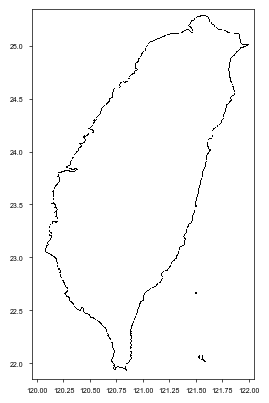

In [12]:
plt.imshow(boundary, extent = extent_binary_extent, cmap = ListedColormap(['white', 'black']))

In [13]:
occ_path = os.path.join(sp_inf['dir_base'], sp_inf['file_name'][species][date])
with rasterio.open(occ_path, 'r') as f:
    img = f.read(1)
long, lat = rasterio.transform.xy(transform, np.where(img == 1)[0], np.where(img == 1)[1], offset='center')

fig, ax = plt.subplots(figsize = mm2inch(60, 100), gridspec_kw = {'left': 0, 'right': 1, 'bottom': 0, 'top': 1})
ax.imshow(boundary, cmap = ListedColormap(['white', 'black']), extent = extent_binary_extent)
# ax.axis('off')
ax.set_xticks([])
ax.set_yticks([])
ax.scatter(long, lat, color = 'black', s = 10)
# plt.savefig(os.path.join(plot_path_flowchart, f'occ_{species}.pdf'), dpi = 500, transparent = True)
plt.show()

NameError: name 'species' is not defined

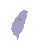

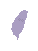

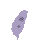

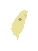

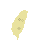

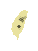

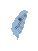

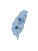

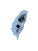

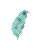

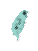

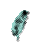

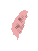

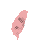

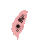

In [14]:
plot_path_flowchart_occ = os.path.join(plot_path_flowchart, 'occurrence')
create_folder(plot_path_flowchart_occ)
for i_sp, species in enumerate(species_img):
    for date in date_img:
        occ_path = os.path.join(sp_inf['dir_base'], sp_inf['file_name'][species][date])
        with rasterio.open(occ_path, 'r') as f:
            img = f.read(1)
        long, lat = rasterio.transform.xy(transform, np.where(img == 1)[0], np.where(img == 1)[1], offset='center')

        fig, ax = plt.subplots(figsize = mm2inch(5, 8), gridspec_kw={'left' : 0, 'bottom' : 0, 'top' : 1, 'right' : 1})
        ax.imshow(extent_binary, cmap = ListedColormap(['none', color_img[i_sp]]), extent = extent_binary_extent, alpha = 0.5)
        ax.axis('off')
        ax.scatter(long, lat, color = 'black', s = 0.005)
        
        path_output = os.path.join(plot_path_flowchart_occ, f'{species}_{date}_occ.pdf')
        plt.savefig(path_output, dpi = 2000, transparent = True)
        

# environmental variables

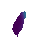

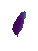

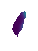

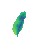

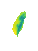

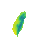

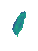

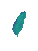

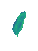

In [15]:
plot_path_flowchart_env = os.path.join(plot_path_flowchart, 'environment')
create_folder(plot_path_flowchart_env)
for env in env_img: 
    env_min = 1e100
    env_max = -1e100
    for date in date_img:
        with rasterio.open(os.path.join(env_inf['dir_base'], env_inf['info'][env][date]['tif_span_avg']), 'r') as f:
            img = f.read(1).copy()
            img = np.where(img == -9999, np.nan, img)
            if np.nanmax(img) > env_max:
                env_max = np.nanmax(img)
            if np.nanmin(img) < env_min:
                env_min = np.nanmin(img)
    for date in date_img:
        with rasterio.open(os.path.join(env_inf['dir_base'], env_inf['info'][env][date]['tif_span_avg']), 'r') as f:
            img = f.read(1).copy()
            img = np.where(img == -9999, np.nan, img)
        fig, ax = plt.subplots(figsize = mm2inch(5, 8), gridspec_kw={'left': 0, 'bottom': 0, 'top': 1, 'right': 1})
        ax.imshow(img, extent = extent_binary_extent, vmin = env_min, vmax = env_max)
        ax.axis('off')
        path_output = os.path.join(plot_path_flowchart_env, f'{env}_{date}.pdf')
        plt.savefig(path_output, dpi = 2000, transparent = True)

# prediction results

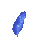

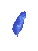

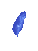

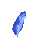

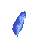

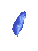

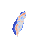

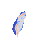

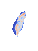

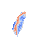

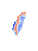

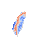

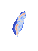

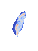

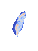

In [25]:
plot_path_flowchart_occ = os.path.join(plot_path_flowchart, 'prediction')
create_folder(plot_path_flowchart_occ)
for i_sp, species in enumerate(species_img):
    file_path = deepsdm_h5_path.replace('[SPECIES]', species)
    for date in date_img:
        with h5py.File(file_path, 'r') as hf:
            rst = hf[date][:].copy()
        
        fig, ax = plt.subplots(figsize = mm2inch(5, 8), gridspec_kw={'left' : 0, 'bottom' : 0, 'top' : 1, 'right' : 1})
        ax.imshow(rst, cmap = 'coolwarm')
        ax.axis('off')
        
        path_output = os.path.join(plot_path_flowchart_occ, f'{species}_{date}_pred.pdf')
        plt.savefig(path_output, dpi = 2000, transparent = True)
        